# Patient trial matching

In [1]:
import os
from pathlib import Path


# Get project directory
def get_project_dir():
    root = Path(os.path.expanduser("~"))
    return f"{root}/github/llm-drug-discovery"


project_dir = get_project_dir()
project_dir

'/home/mgustineli/github/llm-drug-discovery'

In [ ]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

PROJECT_DIR = Path.home() / "github" / "llm-drug-discovery"
DATA_DIR = PROJECT_DIR / "data"
PLOTS_DIR = PROJECT_DIR / "plots"
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

In [ ]:
def load_json(path: Path):
    return json.loads(path.read_text())


# Simple text formatter for patients
def patient_to_text(p):
    d = p["demographics"]
    hist = p["medical_history"]
    return f"{d}. {hist}"


# Simple text formatter for trials
def trial_to_text(t):
    c = t["eligibility_criteria"]
    parts = [
        f"Age between {c['age_min']} and {c['age_max']} years",
        f"Ejection fraction between {c['ef_min']}% and {c['ef_max']}%",
        f"Serum creatinine between {c['creatinine_min']} and {c['creatinine_max']} mg/dL",
        f"Serum sodium between {c['sodium_min']} and {c['sodium_max']} mEq/L",
    ]
    # Add binary criteria
    for key, label in [
        ("anaemia", "anaemia"),
        ("diabetes", "diabetes"),
        ("high_blood_pressure", "high blood pressure"),
        ("smoking", "smoking"),
    ]:
        if c.get(key) is not None:
            parts.append(f"{'With' if c[key] == 1 else 'Without'} {label}")
    # Add sex criterion
    if c.get("sex") is not None:
        parts.append("Male patients only" if c["sex"] == 1 else "Female patients only")
    return f"{t['name']}: " + ". ".join(parts)


# Match patients to trials by TF-IDF threshold
def match_by_tfidf(patient_texts, trial_texts, threshold=0.1):
    vect = TfidfVectorizer(max_features=2000, ngram_range=(1, 2))
    all_texts = patient_texts + trial_texts
    vect.fit(all_texts)
    P = vect.transform(patient_texts)
    T = vect.transform(trial_texts)
    sims = cosine_similarity(T, P)  # trials x patients
    matches = {
        i: np.where(sims[i] >= threshold)[0].tolist() for i in range(len(trial_texts))
    }
    return matches, sims


# Evaluate predictions
def evaluate(preds, actual):
    tp = len(set(preds) & set(actual))
    fp = len(set(preds) - set(actual))
    fn = len(set(actual) - set(preds))
    precision = tp / (tp + fp) if tp + fp else 0
    recall = tp / (tp + fn) if tp + fn else 1
    f1 = 2 * precision * recall / (precision + recall) if precision + recall else 0
    return precision, recall, f1


# Plot performance vs threshold
def plot_metrics(results, out_path):
    df = pd.DataFrame(results)
    plt.figure()
    plt.plot(df["threshold"], df["f1"], marker="o")
    plt.xlabel("Threshold")
    plt.ylabel("F1")
    plt.title("Threshold vs F1")
    plt.grid(True)
    plt.savefig(out_path)
    plt.close()

Best threshold: 0.05


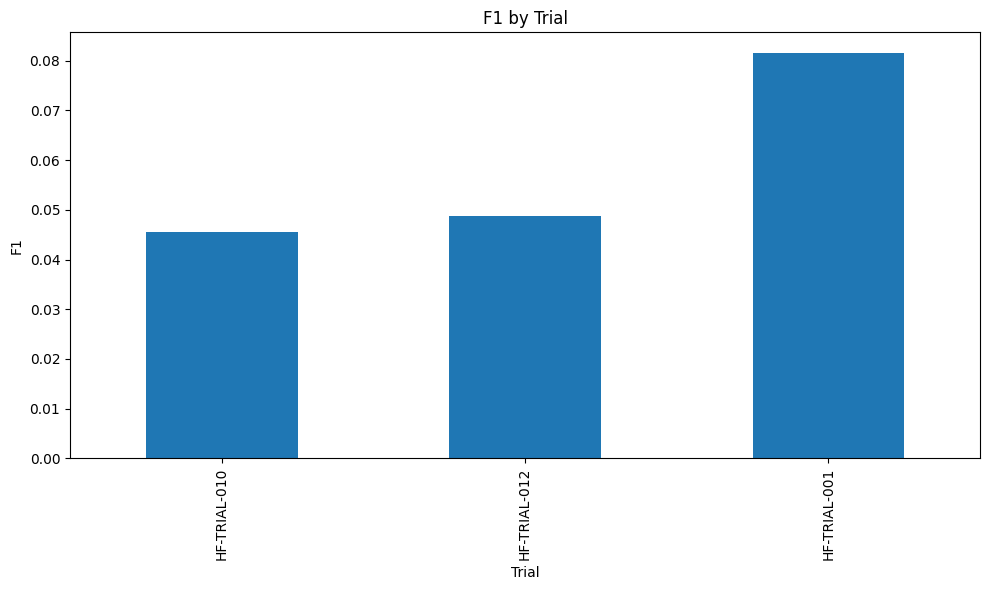

In [15]:
# Load data
patients = load_json(DATA_DIR / "test_patients.json")
trials = load_json(DATA_DIR / "test_trials.json")

# Prepare texts and actual eligible lists
pt_texts = [patient_to_text(p) for p in patients]
tr_texts = [trial_to_text(t) for t in trials]
actual = {i: t["eligible_patients"] for i, t in enumerate(trials)}

# Search optimal threshold on test set
thresholds = np.linspace(0.05, 0.3, 6)
results = []
for thr in thresholds:
    matches, _ = match_by_tfidf(pt_texts, tr_texts, threshold=thr)
    metrics = [evaluate(matches[i], actual[i]) for i in actual]
    precisions, recalls, f1s = zip(*metrics)
    results.append(
        {
            "threshold": thr,
            "precision": np.mean(precisions),
            "recall": np.mean(recalls),
            "f1": np.mean(f1s),
        }
    )
# Plot and choose best
plot_metrics(results, PLOTS_DIR / "threshold_vs_f1.png")
best = max(results, key=lambda x: x["f1"])["threshold"]
print(f"Best threshold: {best}")

# Final evaluation
matches, sims = match_by_tfidf(pt_texts, tr_texts, threshold=best)
eval_data = []
for i in actual:
    p, r, f = evaluate(matches[i], actual[i])
    eval_data.append({"trial": trials[i]["id"], "precision": p, "recall": r, "f1": f})
df_eval = pd.DataFrame(eval_data)
df_eval.to_csv(DATA_DIR / "matching_eval.csv", index=False)

# Bar plot of F1 per trial
plt.figure(figsize=(10, 6))
df_eval.set_index("trial")["f1"].plot(kind="bar")
plt.title("F1 by Trial")
plt.xlabel("Trial")
plt.ylabel("F1")
plt.tight_layout()
plt.savefig(PLOTS_DIR / "f1_by_trial.png")